In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patheffects as path_effects
from shapely.geometry import Point, mapping, box
from matplotlib.patches import Rectangle
import matplotlib as mpl

## Import the files from each component and merge into dataframe

In [2]:
hazard = pd.read_csv("DataMap_Outputs/Hazard_Scoring_OutputCH.csv")
exposure = pd.read_csv("DataMap_Outputs/Pareto_Output_CH.csv")
vulnerability = pd.read_csv("DataMap_Outputs/Vulnerability_Output_CH.csv")
completeness = pd.read_csv("Data_Inputs/Data_Completeness_Scores_CH.csv", encoding='latin1')

/var/folders/4z/b9m499n155zbs7jwbc5_11mr0000gn/T/ipykernel_5992/1758217764.py:4: DtypeWarning: Columns (0,1,2,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  completeness = pd.read_csv("Data_Inputs/Data_Completeness_Scores_CH.csv", encoding='latin1')


In [3]:
merged_df = hazard.copy()
merged_df = merged_df.merge(
    exposure[["Volcanic Centre Name", "LAT_CENTRE", "LON_CENTRE", "Exposure_Pareto_Front"]], 
    on=["Volcanic Centre Name", "LAT_CENTRE", "LON_CENTRE"],
    how='left')
merged_df = merged_df.merge(
    vulnerability[["LAT_CENTRE", "LON_CENTRE", "vulnerability"]], 
    on=[ "LAT_CENTRE", "LON_CENTRE"],
    how='left')
merged_df = merged_df.merge(
    completeness[["LAT_CENTRE", "LON_CENTRE", "Total data availability score"]], 
    on=["LAT_CENTRE", "LON_CENTRE"],
    how='left')

In [4]:
vuln_max = merged_df["vulnerability"].max()

## Assign variables to each component and calculate final priority ranking for each eruptive centre

In [5]:
results = []
min_r, max_r = 1, 5
for idx, row in merged_df.iterrows():
    name       = row["Volcanic Centre Name"]
    lat        = row["LAT_CENTRE"]
    lon        = row["LON_CENTRE"]

    haz_score = row["Total_Hazard_Score"]
    expo_score = row["Exposure_Pareto_Front"]
    vuln_score = row["vulnerability"]
    comp_score = row["Total data availability score"]

    haz_norm = haz_score/20
    expo_norm = (expo_score - min_r) / (max_r - min_r)
    vuln_norm = vuln_score / vuln_max
    comp_norm = comp_score/12

    expo_inv  = 1 - expo_norm
    comp_inv  = 1 - comp_norm

    haz_weight = 0.1
    expo_weight = 0.35
    vuln_weight = 0.4
    comp_weight = 0.15
    
    haz_cont = haz_norm * haz_weight
    expo_cont = expo_inv * expo_weight
    vuln_cont = vuln_norm * vuln_weight
    comp_cont = comp_inv * comp_weight


    final_score = haz_cont + expo_cont + vuln_cont + comp_cont
    haz_pct   = haz_norm   * 100
    expo_pct   = expo_inv  * 100
    vuln_pct  = vuln_norm  * 100
    comp_pct  = comp_inv   * 100
    final_pct = final_score * 100
    
    results.append({
    "Volcanic Centre Name":    name,
    "Latitude":                lat,
    "Longitude":               lon,
    "Hazard Score (raw)":      haz_score,
    "Hazard (%)":              haz_pct,
    "Hazard contrib (%)":      haz_cont * 100,
    "Exposure Score (raw)":    expo_score,
    "Exposure (%)":            expo_pct,
    "Exposure contrib (%)":    expo_cont * 100,
    "Vulnerability (raw)":     vuln_score,
    "Vulnerability (%)":       vuln_pct,
    "Vulnerability contrib (%)": vuln_cont * 100,
    "Data completeness (raw)": comp_score,
    "Data gap (%)":            comp_pct,
    "Data gap contrib (%)":    comp_cont * 100,
    "Final score (0–1)":       final_score,
    "Final score (%)":         final_pct
})


df_results = pd.DataFrame(results)

## Export Data 

In [6]:
df_results.to_csv("DataMap_Outputs/Final_Volcano_Scoring.csv")

## Mapping Results

In [7]:
volcano_gdf = gpd.GeoDataFrame(
    df_results, 
    geometry=gpd.points_from_xy(merged_df["LON_CENTRE"], merged_df["LAT_CENTRE"]),
    crs="EPSG:4326"
)


In [8]:
LGAS= gpd.read_file("NVP_Locations/LGAS_Decile.gpkg")
colac_lin = gpd.read_file("NVP_Locations/colac_lineament.gpkg")
shapefile = gpd.read_file("Aus_Shapefile/STE_2021_AUST_GDA2020.shp")
CH = gpd.read_file("NVP_Locations/subProvincesAndRegions.gdb", layer="CentralHighlands")
CH = CH.to_crs(LGAS.crs)

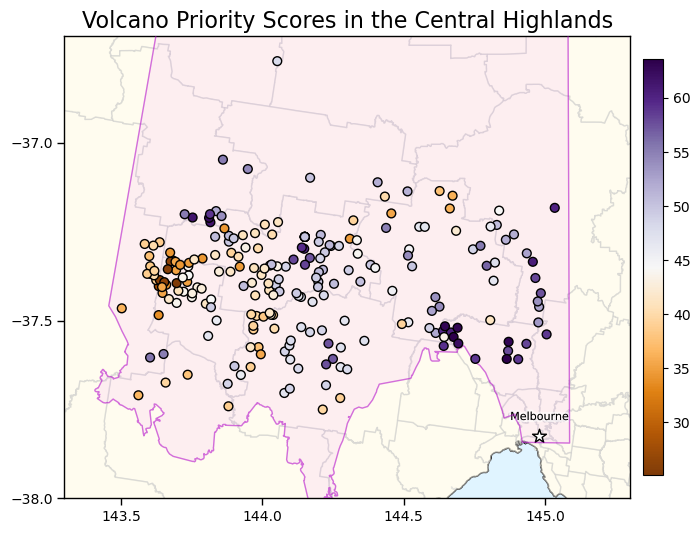

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4, alpha=0.5)


volcano_plot = volcano_gdf.plot(
    ax=ax,
    column="Final score (%)",
    cmap="PuOr",
    markersize=40,
    edgecolor="black",
    zorder=5,
    legend=True,
    legend_kwds={
    "shrink": 0.9,
    "fraction": 0.05,
    "pad": 0.02           
    })





ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black', zorder=3, marker='*',  s=110) #Melbourne
Melbourne = ax.annotate(
    'Melbourne',         
    xy=(144.97806, -37.8240),
    xytext=(144.98, -37.78),        
    fontsize=8,
    color='black',
    ha="center"
)
Melbourne.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")




ax.set_facecolor('#e0f4ff')
ax.set_xlim(143.3, 145.3)
ax.set_ylim(-38,-36.7)
ax.set_xticks([143.5, 144, 144.5, 145])
ax.set_yticks([-37, -37.5, -38])
ax.tick_params(axis="both", which="both", direction="out", length=5, width=1, colors="black")
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title("Volcano Priority Scores in the Central Highlands", fontsize=16)


ax.set_axis_on()


plt.savefig("DataMap_Outputs/Final_Priority_Scores.png", dpi=600)
plt.show()

## Zoom in on area of interest (optional)

In [ ]:
gdf_cgf = gpd.read_file(
    "Data_Inputs/LGAVulnerability.gpkg",
    where="LGA_NAME_2023 = 'CENTRAL GOLDFIELDS'") 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4, alpha=0.5)
gdf_cgf.plot(ax=ax, facecolor='none', edgecolor='black', zorder=5, alpha=0.6)


volcano_plot = volcano_gdf.plot(
    ax=ax,
    column="Final score (%)",
    cmap="PuOr",
    markersize=40,
    edgecolor="black",
    zorder=5,
    legend=True
)


Merin = ax.annotate(
    'Merin Hill',
    xy=(143.8114, -37.2111),
    xytext=(143.72, -37.17),
    fontsize=11,
    color='black',
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=6)
)

CG = ax.annotate(
    'Central\nGoldfields',         
    xy=(143.7, -37),               
    xytext=(143.72, -37.07),
    wrap=True,         
    fontsize=8,
    color='grey',
    ha="center"
)
CG.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])


for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")


ax.set_facecolor('#e0f4ff')
ax.set_xlim(143.6, 144)
ax.set_ylim(-37.4,-37)

ax.tick_params(axis="both", which="both", direction="out", length=5, width=1, colors="black")
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title("Volcano Priority Scores in Central Goldfields", fontsize=16)


ax.set_axis_on()

plt.savefig("DataMap_Outputs/Final_Goldfields_Scores.png", dpi=600)
plt.show()

In [10]:
fairbanks = volcano_gdf[volcano_gdf["Volcanic Centre Name"] == "Fairbanks Hill"]
other_points  = volcano_gdf[volcano_gdf["Volcanic Centre Name"] != "Fairbanks Hill"]

In [11]:
norm = mpl.colors.Normalize(
    vmin=volcano_gdf["Final score (%)"].min(),
    vmax=volcano_gdf["Final score (%)"].max()
)
cmap = plt.colormaps.get_cmap("PuOr")

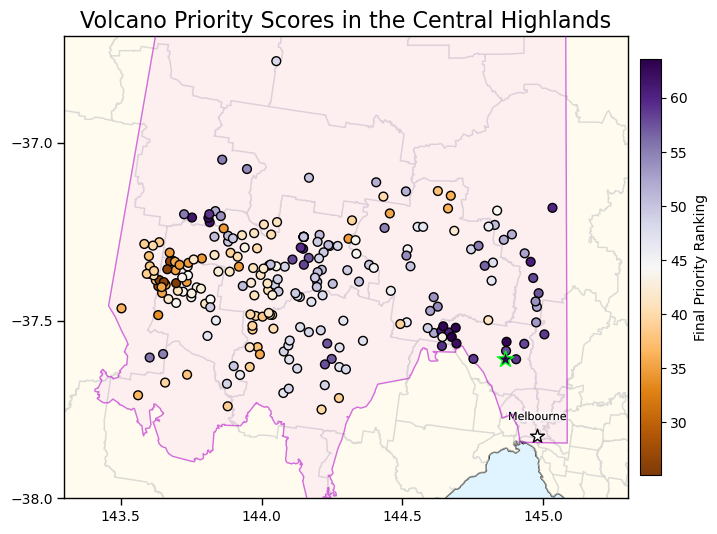

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
LGAS.plot(ax=ax,color='#fffbe0', edgecolor='#CCCCCC', zorder=1, alpha=0.5)
shapefile.plot(ax=ax, color='white',edgecolor='black', zorder=0)
CH.plot(ax=ax, color='#ef78ff', edgecolor='#b102c9', alpha=0.1, zorder=2)
CH.plot(ax=ax, facecolor='none', edgecolor='#b102c9', zorder=4, alpha=0.5)


other_points.plot(
    ax=ax,
    column="Final score (%)",
    cmap=cmap,
    norm=norm,
    markersize=40,
    edgecolor="black",
    zorder=5,
    legend=True,
    legend_kwds={
        "label": "Final Priority Ranking",
        "shrink": 0.9,
        "fraction": 0.05,
        "pad": 0.02           
    }
)

# Plot the special volcano as a star
fairbanks.plot(
    ax=ax,
    column="Final score (%)",
    cmap=cmap,
    norm=norm,
    markersize=150,  
    edgecolor="#03fc17",   
    marker="*",            
    zorder=5
)



ax.scatter(144.97806, -37.8240, facecolor='white', edgecolor='black', zorder=3, marker='*',  s=110) #Melbourne
Melbourne = ax.annotate(
    'Melbourne',         
    xy=(144.97806, -37.8240),
    xytext=(144.98, -37.78),        
    fontsize=8,
    color='black',
    ha="center"
)
Melbourne.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground=(1, 1, 1, 0.6)),
    path_effects.Normal()
    ])



for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor("black")


ax.set_facecolor('#e0f4ff')
ax.set_xlim(143.3, 145.3)
ax.set_ylim(-38,-36.7)
ax.set_xticks([143.5, 144, 144.5, 145])
ax.set_yticks([-37, -37.5, -38])
ax.tick_params(axis="both", which="both", direction="out", length=5, width=1, colors="black")
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title("Volcano Priority Scores in the Central Highlands", fontsize=16)


ax.set_axis_on()


plt.savefig("DataMap_Outputs/Final_Priority_Scores_Seminar.png", dpi=600)
plt.show()